## mRKS method

Please check the original paper:\
\[1\] [Ryabinkin, Kohut and Staroverov, PRL 115, 083001 (2015)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.083001) \
\[2\] [Ospadov, Ryabinkin and Staroverov, J. Chem. Phys. 146, 084103 (2017)](https://doi.org/10.1063/1.4975990) \
\[3\] [Staroverov, Ospadov, Advances in Quantum Chemistry, Volume 79 (2019)](https://doi.org/10.1016/bs.aiq.2019.04.002).

First, build the input wavefunction using Psi4. Note that currently only Psi4.CIWavefunction supports two-particle density matrices (tpdm). CISD is used in this example.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.set_num_threads(4)
psi4.core.clean()

import n2v

In [2]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf",
                  "opdm": True,
                  "tpdm": True,
                  'DFT_SPHERICAL_POINTS': 974,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 210,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                 })  # Spin-Restricted

# IMPORTANT NOTE: ONLY psi4.CIWavefunction or RHF is supported.
wfn = psi4.energy("DETCI/cc-pvdz", return_wfn=True, molecule=Ne)[1]

ine = n2v.Inverter(wfn)

Let's first try calculating $v_{xc}$ on DFT shperical grid.\
This grid is automatically generated by Psi4 for doing DFT vxc integrals.

In [3]:
v = ine.invert("mRKS", opt_max_iter=15, frac_old=0.3)

The guide potential is changed to v_hartree.
Memory taken by ERI integral matrix and 2pdm is about: 0.001 GB.
vxchole quadrature double integral starts (177268 points): ..........

Totally 177268 grid points takes 4031.62s with max 256 points in a block.
Iter: 1, Density Change: 8.54e-03, Eigenvalue Change: 6.07e+00, Potential Change: 8.32e+00.
Iter: 2, Density Change: 1.58e-04, Eigenvalue Change: 1.27e-01, Potential Change: 1.10e-01.
Iter: 3, Density Change: 6.74e-05, Eigenvalue Change: 7.07e-03, Potential Change: 5.35e-02.
Iter: 4, Density Change: 2.45e-05, Eigenvalue Change: 4.26e-03, Potential Change: 4.49e-02.
Iter: 5, Density Change: 2.26e-06, Eigenvalue Change: 4.48e-03, Potential Change: 4.23e-02.
Iter: 6, Density Change: 6.18e-06, Eigenvalue Change: 4.12e-03, Potential Change: 3.96e-02.
Iter: 7, Density Change: 4.42e-06, Eigenvalue Change: 3.90e-03, Potential Change: 3.71e-02.
Iter: 8, Density Change: 4.48e-06, Eigenvalue Change: 3.65e-03, Potential Change: 3.48e-02.
Iter: 9, 

In [4]:
x,y,z,_ = ine.Vpot.get_np_xyzw()

mask = np.bitwise_and(np.isclose(y, 0), np.isclose(z,0))
order = np.argsort(x[mask])

x_plot = x[mask][order]
vxc_plot = v[0][mask][order]

(-5, 5)

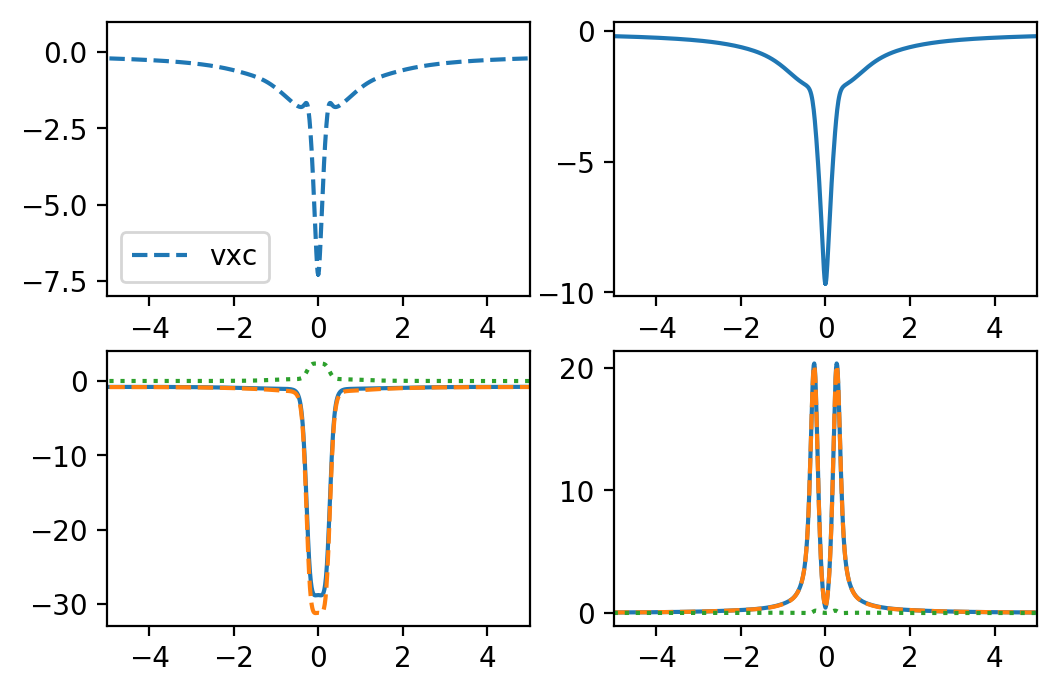

In [5]:
fig, axes = plt.subplots(2,2,dpi=200)
axes[0,0].plot(x_plot, vxc_plot, label="vxc", ls="--")
axes[0, 0].set_xlim(-5,5)
axes[0, 0].set_ylim(-8,1)
axes[0, 0].legend()

axes[0,1].plot(x_plot, v[1][mask][order])
axes[0, 1].set_xlim(-5,5)

axes[1,0].plot(x_plot, v[2][mask][order])
axes[1,0].plot(x_plot, v[3][mask][order], ls='--')
axes[1,0].plot(x_plot, v[2][mask][order]-v[3][mask][order], ls=":")
axes[1, 0].set_xlim(-5,5)

axes[1,1].plot(x_plot, v[4][mask][order])
axes[1,1].plot(x_plot, v[5][mask][order], ls='--')
axes[1,1].plot(x_plot, v[4][mask][order]-v[5][mask][order], ls=":")
axes[1,1].set_xlim(-5,5)


If a user specified grid is needed (which is usually the case), one should give the grid infomation before the calculation, as shown following:

In [6]:
x = np.linspace(-5,5,1001)
y = [0]
z = [0]
grid, shape = ine.generate_grids(x,y,z)
grid.shape

(3, 1001)

In [7]:
v = ine.invert("mRKS", opt_max_iter=15, frac_old=0.3, vxc_grid=grid,
              init="pbe" # Set initial guess to be pbe this time.
              )

The guide potential is changed to v_hartree.
Memory taken by ERI integral matrix and 2pdm is about: 0.001 GB.
Iter: 1, Density Change: 8.53e-03, Eigenvalue Change: 6.10e+00, Potential Change: 8.57e+00.
Iter: 2, Density Change: 9.25e-05, Eigenvalue Change: 1.38e-01, Potential Change: 8.82e-02.
Iter: 3, Density Change: 3.57e-05, Eigenvalue Change: 8.28e-03, Potential Change: 7.21e-02.
Iter: 4, Density Change: 1.92e-05, Eigenvalue Change: 6.68e-03, Potential Change: 6.57e-02.
Iter: 5, Density Change: 5.29e-06, Eigenvalue Change: 6.51e-03, Potential Change: 6.18e-02.
Iter: 6, Density Change: 7.99e-06, Eigenvalue Change: 6.05e-03, Potential Change: 5.78e-02.
Iter: 7, Density Change: 6.67e-06, Eigenvalue Change: 5.68e-03, Potential Change: 5.41e-02.
Iter: 8, Density Change: 6.46e-06, Eigenvalue Change: 5.31e-03, Potential Change: 5.07e-02.
Iter: 9, Density Change: 6.00e-06, Eigenvalue Change: 4.98e-03, Potential Change: 4.75e-02.
Iter: 10, Density Change: 5.63e-06, Eigenvalue Change: 4.66e-0

In [8]:
Ne = np.genfromtxt('Ne.dat')
Ne_xyz = np.concatenate((-np.flip(Ne[:, 1]), Ne[:, 1]))
Ne_vxc = np.concatenate((np.flip(Ne[:, 3]), Ne[:, 3]))

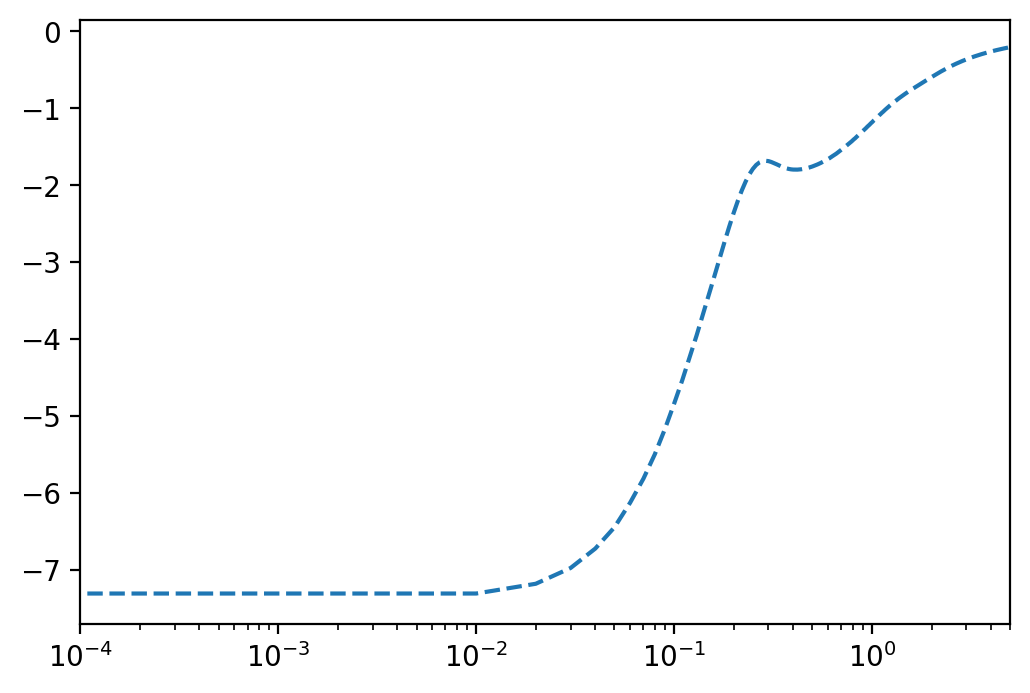

In [15]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x, v[0], ls="--")
ax.set_xlim(1e-4, 5)
ax.set_xscale("log")